In [1]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from scipy import integrate


In [2]:
DATA_PATH = "./data/"


In [3]:
diego_t = pd.read_pickle(DATA_PATH+"/features/T.pickle")
diego_nt = pd.read_pickle(DATA_PATH+"/features/NT.pickle")
print(diego_t.shape)

(46959, 32)


In [4]:
all_diego = pd.concat([diego_nt,diego_t])

In [5]:
all_diego['bin_class'] = all_diego['Class']=="SN"
all_diego["fact_Class"] = pd.factorize(all_diego['bin_class'])[0]

In [6]:
all_diego.tail()


,,Class,ObsCount,amplitude,beyond1st,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,kurtosis,...,poly4_t2,poly4_t3,poly4_t4,skew,small_kurtosis,std,stetson_j,stetson_k,bin_class,fact_Class
ID,copy_num,,,,,,,,,,,,,,,,,,,,,
TranID1310131381024102178,10,SN,7,0.360233,0.142857,0.159294,0.288508,0.495671,0.702834,0.882508,2.395244,...,-382.104064,-1.942155e+01,5.596853e+00,1.661791,-5.400000,0.261047,0.542345,0.867954,True,1
TranID1009110011274140658,10,CV,19,1.620788,0.526316,0.004615,0.008413,0.013528,0.029901,0.835680,0.681493,...,-0.000005,1.501891e-09,4.993123e-12,-1.215647,-3.573529,0.976924,3.151000,0.559249,False,0
TranID1006191261154142735,10,SN,7,1.587182,0.142857,0.063803,0.130331,0.346260,0.562190,0.822649,3.165782,...,-0.060319,-2.832678e-06,2.576439e-08,1.564664,-5.400000,1.036647,-0.404262,0.756193,True,1
TranID1409031291124154648,10,CV,37,1.602574,0.297297,0.102388,0.249139,0.461230,0.513607,0.760052,-0.107470,...,-0.000001,-1.417808e-09,7.777308e-13,0.831387,-3.267227,0.823078,1.710220,0.831793,False,0
TranID1209190181234125108,10,SN,16,0.597726,0.250000,0.113485,0.252952,0.347970,0.475463,0.723253,2.013827,...,-0.150831,4.647583e-06,1.943760e-04,1.250014,-3.708791,0.299568,0.477280,0.788695,True,1


In [14]:
all_diego = all_diego.sample(frac=1)

In [15]:
all_train, all_test= train_test_split(all_diego,test_size = 0.25)

In [16]:
all_train = all_train.sample(frac=1)
all_test = all_test.sample(frac=1)

## Remove oversampled data on test to reduce bias

In [17]:
all_test = all_test.iloc[all_test.index.get_level_values('copy_num') == 0]

In [18]:
features = all_train.columns[2:-2]
print(features)
y_train = np.array(all_train['fact_Class'])
y_test = np.array(all_test['fact_Class'])


Index(['amplitude', 'beyond1st', 'flux_percentile_ratio_mid20',
       'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50',
       'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80',
       'kurtosis', 'max_slope', 'median_absolute_deviation',
       'median_buffer_range_percentage', 'pair_slope_trend',
       'pair_slope_trend_last_30', 'percent_amplitude',
       'percent_difference_flux_percentile', 'poly1_t1', 'poly2_t1',
       'poly2_t2', 'poly3_t1', 'poly3_t2', 'poly3_t3', 'poly4_t1', 'poly4_t2',
       'poly4_t3', 'poly4_t4', 'skew', 'small_kurtosis', 'std', 'stetson_j',
       'stetson_k'],
      dtype='object')


In [19]:
print(len(y_train))
print(len(y_test))


46614
4806


In [20]:
clf = RandomForestClassifier(n_estimators=50,random_state=0, class_weight='balanced')
clf.fit(all_train[features], y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [21]:
clf.score(all_test[features],y_test)

0.9721181856013317

In [22]:
preds = clf.predict(all_test[features])
pd.crosstab(preds, y_test, rownames=['Predicted '], colnames=['Actual '])

Actual,0,1
Predicted,,
0,4475,109
1,25,197


In [23]:
2430/(2430+220)

0.9169811320754717

In [24]:
tp = pd.crosstab(preds, y_test, rownames=['Predicted '], colnames=['Actual '])[1][1]
tn = pd.crosstab(preds, y_test, rownames=['Predicted '], colnames=['Actual '])[0][0]
fp = pd.crosstab(preds, y_test, rownames=['Predicted '], colnames=['Actual '])[0][1]
fn = pd.crosstab(preds, y_test, rownames=['Predicted '], colnames=['Actual '])[1][0]
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1  = 2*precision*recall/(precision+recall)
accuracy = (tp+tn)/(tp+tn+fp+fn)
print('precision ',precision)
print('recall ', recall)
print('f1 ',f1)
print('accuracy ',accuracy)

precision  0.8873873873873874
recall  0.6437908496732027
f1  0.7462121212121212
accuracy  0.9721181856013317


In [25]:
print((tp+tn)/(tp+tn+fp+fn))

0.9721181856013317


In [26]:
pd.crosstab(preds, y_test, rownames=['Predicted '], colnames=['Actual '])[0][1]

25

Text(0.5,1,'Transients + non-transients - Magnitude')

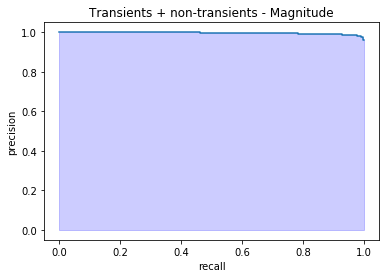

In [27]:

preds1 = clf.predict_proba(all_test[features])
precision, recall, _ = precision_recall_curve(y_test, preds1[:,0],pos_label=0)

plt.step(recall,precision)
plt.fill_between(recall, precision,step='pre', alpha=0.2,
                 color='b')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Transients + non-transients - Magnitude')


In [28]:
integrate.trapz(precision[::-1],recall[::-1])

0.9960519683579392

In [29]:
preds = clf.predict(all_test[features])
pd.crosstab(preds, y_test, rownames=['Predicted '], colnames=['Actual '])

Actual,0,1
Predicted,,
0,4475,109
1,25,197


In [30]:

f1_score(np.array(preds),np.array(y_test))

0.7462121212121212

In [29]:
precision_score(preds,y_test)

0.6831599662637053

In [31]:
accuracy_score(preds,y_test)

0.9133093062170163

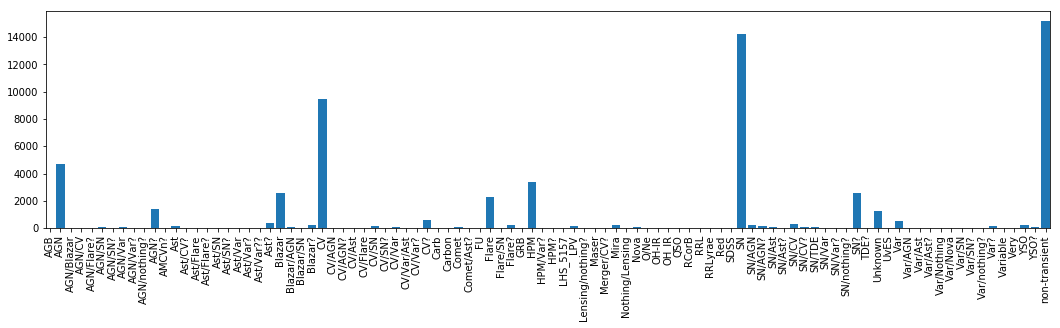

In [21]:
dfs = {}
for clase in all_diego.reset_index().Class.unique():
    dfs[clase] = all_diego[all_diego['Class']==clase]

numObjs = {}
for k in dfs.keys():
    numObjs[k] = len(dfs[k])

plt.bar(numObjs.keys(),numObjs.values())
plt.xticks(rotation='vertical')

N = len(numObjs)
plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
s = maxsize/plt.gcf().dpi*N+2*m
margin = m/plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])
